In [235]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import add_dummy_feature
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

import scikitplot as skplt
import mord

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve

from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Load and Explore Data

In [236]:
df = pd.read_csv('winequality-red.csv', delimiter=';')

In [237]:
# Relabel
# df.quality = pd.cut(df.quality, bins=3, labels=[1, 2, 3]).astype('int')
df.quality = df.quality.map(lambda x: x-3)

In [275]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2


### Subset Data

In [238]:
df_subset = df.copy()
df_subset['quality2'] = pd.cut(df.quality, bins=3, labels=[1, 2, 3]).astype('int') #['good', 'medium', 'bad'])

### Split Data 

In [276]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [279]:
# Split 
# y = resampled_df.quality
# X = resampled_df.drop(columns='quality')

# y = df_subset.quality2
# X = df_subset.drop(columns=['quality', 'quality2'])

y = df.quality
X = df[['fixed acidity', 'volatile acidity', 'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]

# y = df.quality
# X = df.drop(columns='quality')

# X = df[['volatile acidity', 'citric acid', 'total sulfur dioxide', 'density', 'alcohol']]
# X = df[['volatile acidity', 'alcohol']]

# # Make sure intercept exists
# if ~any(X.columns == 'Intercept'):
#     X.insert(0, 'Intercept', 1)
# else: 
#     X.Intercept = 1
    
# Stratified Split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, stratify=y, test_size=.7, random_state=129)

In [300]:
def normalize_confusion_matrix(cm):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    
    cm = (cm - np.min(cm)) / (np.max(cm) - np.min(cm))
    
    return cm

In [301]:
def discrete_heatmap(cm):
    
    ### Discrete Confusion Matrix Heatmap
    from sklearn.preprocessing import normalize
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(figsize=(10, 6))

    #     # Normalize across predictions
    #     norm_Z = normalize(cm, axis=1)
    #     # Normalize across predictions and truth [Note: Use this if classes are balanced]
    #     norm_Z = (Z - np.min(Z)) / (np.max(Z) - np.min(Z))

    #     norm_Z = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     norm_Z = np.around(norm_Z, decimals=2)
    #     norm_Z[np.isnan(norm_Z)] = 0.0
    
    Z = normalize_confusion_matrix(cm)

    # Generate heatmap
    sns.heatmap(Z, cmap='RdYlGn', annot=True, cbar=True)

    ## Format axes object
    #  Format X-axis label and ticks
    ax.set_xlabel('Predicted', fontdict={'size': 12})
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    # Format Y-axis label
    ax.set_ylabel('Truth', fontdict={'size': 12})
    # Format Title [Note: double newlines are to create space between Title and the X-axis label that was moved to the top]
    ax.set_title('Red Wine Quality Confusion Matrix\n\n', fontdict={'size': 14, 'weight': 'bold'})

In [302]:
def interpolated_heatmap(cm):
    
    ### Interpolated Confusion Matrix Heatmap
    import numpy as np
    from sklearn.preprocessing import normalize
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(10, 6))

    #     # Normalize across predictions [Note: Use this if classes are imbalanced]
    #     norm_Z = normalize(cm, axis=1)
    #     # Normalize across predictions and truth [Note: Use this if classes are balanced]
    #     norm_Z = (Z - np.min(Z)) / (np.max(Z) - np.min(Z))

    #     norm_Z = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     norm_Z = np.around(norm_Z, decimals=2)
    #     norm_Z[np.isnan(norm_Z)] = 0.0
    
    Z = normalize_confusion_matrix(cm)

    # Generate X, Y indices of confusion matrix
    n_classes = Z.shape[0]
    X, Y = np.meshgrid(np.arange(0, n_classes, 1), np.arange(n_classes-1, -1, -1))

    # Plot contours
    plt.contourf(X, Y, Z, 25, cmap='RdYlGn')#, vmin=0, vmax=1)
    ax2 = plt.colorbar();

    ## Format X-axis label and ticks
    ax.set_xlabel('Predicted', fontdict={'size': 12})
    # Move ticks and label to top
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    # Hide major tick labels
    ax.set_xticklabels([], minor=False) 
    # Create minor ticks in between and label every other one
    ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5], minor=True)
    ax.set_xticklabels(['Low', '', 'Med', '', 'High'], minor=True)

    ## Format Y-axis label and ticks
    ax.set_ylabel('Truth', fontdict={'size': 12})
    # Hide major tick labels
    ax.set_yticklabels([], minor=False)
    # Create minor ticks in between and label every other one
    ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5], minor=True)
    ax.set_yticklabels(['High', '', 'Med', '', 'Low'], minor=True)

    # Format Title [Note: double newlines are to create space between Title and the X-axis label that was moved to the top]
    ax.set_title('Red Wine Quality\n\n', fontdict={'size': 14, 'weight': 'bold'})

In [303]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2


In [304]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,2.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,2.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,3.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,3.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,5.000000


### Build Models

In [268]:
def error_distance_cost(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    cm = normalize_confusion_matrix(cm)
    
    cost = np.zeros_like(cm)
    rows, cols = cm.shape
    for ridx in range(rows):
        for cidx in range(cols):
            cost[ridx, cidx] = np.abs(ridx-cidx) * cm[ridx, cidx]

    return np.around(1/np.sum(cost), decimals=5)

def f1(y_true, y_pred):
    
    return f1_score(y_true, y_pred, average='macro')

In [247]:
print(searchcv.best_score_)
print(1 / searchcv.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [248]:
searchcv.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
searchcv.cv_results_

In [ ]:
searchcv.cv_results_['mean_test_F1'][searchcv.cv_results_['mean_test_ErrorDistance'] == searchcv.best_score_]

In [ ]:
searchcv.cv_results_

In [285]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2


In [286]:
df_result = pd.concat([pd.Series(lr2_pred, name='Class'), pd.DataFrame(lr2_probas)], 
                      axis=1, names=[str(c) for c in range(lr2_probas.shape[1])])
df_result

,Class,0,1,2,3,4,5
0,2,1.943175e-45,0.083539,0.798712,0.102216,0.015533,5.721206e-09
1,2,2.362459e-19,0.008443,0.625100,0.207649,0.158308,5.005361e-04
2,1,1.584987e-07,0.608026,0.139722,0.194532,0.057657,6.322780e-05
3,3,6.757836e-28,0.064860,0.211936,0.544238,0.178961,5.148416e-06
4,2,1.945134e-32,0.058446,0.778625,0.144538,0.018391,2.051428e-09
5,2,1.088287e-16,0.006296,0.481609,0.304153,0.207554,3.873007e-04
6,1,7.416265e-08,0.381789,0.292922,0.258233,0.067037,1.811191e-05
7,3,3.375828e-14,0.004499,0.012529,0.499382,0.480283,3.306469e-03
8,1,1.584987e-07,0.608026,0.139722,0.194532,0.057657,6.322780e-05
9,2,7.831085e-44,0.007657,0.865144,0.109066,0.018133,2.139110e-10


In [287]:
lr2.coef_.shape

(6, 12)

In [320]:
lr2.coef_.shape

(6, 7)

In [289]:
lr2.intercept_

array([-41.2563282 ,  -1.62843506,   4.04291843,  -1.7097751 ,
        -3.18340568,  -1.66660439])

In [305]:
lr1 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='ovr',
                         solver='liblinear')
pipe1 = make_pipeline(StandardScaler(), lr2)

pipe1.fit(X_train, y_train)

print(pipe1)

# make predictions
lr1_pred = pipe1.predict(X_test)
lr1_probas = pipe1.predict_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr1_pred))
print(confusion_matrix(y_test, lr1_pred))

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=129,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
             precision    recall  f1-score   support

          0       0.04      0.29      0.06         7
          1       0.17      0.30      0.21        37
          2       0.62      0.69      0.65       477
          3       0.50      0.32      0.39       447
          4       0.41      0.40      0.40       139
          5       0.07      0.31      0.12        13

avg / total       0.52      0.48      0.49      1120

[[  2   2   3   0   0   0]
 [  5  11  12   8   0   1]
 [ 23  36 327  73   9   9]
 [ 21  16 176 141  70  23]
 [  6   1   7  52  56  17]
 [  0   0   0   6   3   4]]

In [306]:
lr2 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='ovr',
                         solver='liblinear')
lr2.fit(X_train, y_train)
# lr2.fit(X_train, y_train).decision_function(X_test, )

print(lr2)

# make predictions
lr2_pred = lr2.predict(X_test)
lr2_probas = lr2.predict_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr2_pred))
print(confusion_matrix(y_test, lr2_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=129,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.04      0.29      0.06         7
          1       0.17      0.30      0.22        37
          2       0.63      0.70      0.66       477
          3       0.54      0.36      0.43       447
          4       0.47      0.41      0.44       139
          5       0.06      0.23      0.09        13

avg / total       0.55      0.51      0.52      1120

[[  2   2   3   0   0   0]
 [  5  11  13   7   0   1]
 [ 24  32 335  70   6  10]
 [ 20  19 174 159  54  21]
 [  6   0   8  51  57  17]
 [  0   0   0   7   3   3]]


In [307]:
adjusted_rand_score(y_test, lr2_pred)

0.15569437634133604

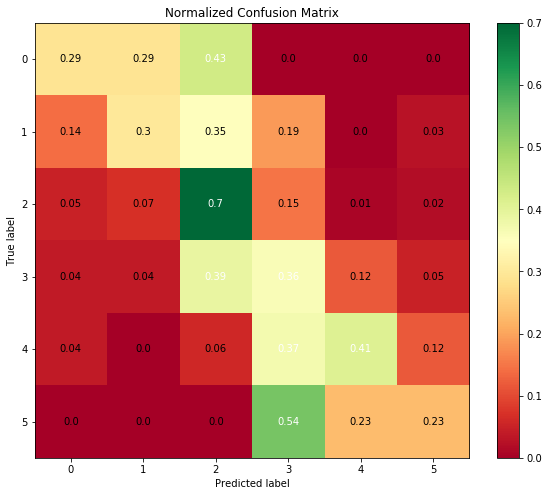

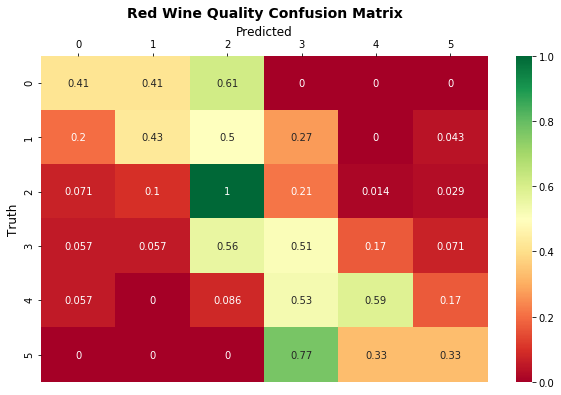

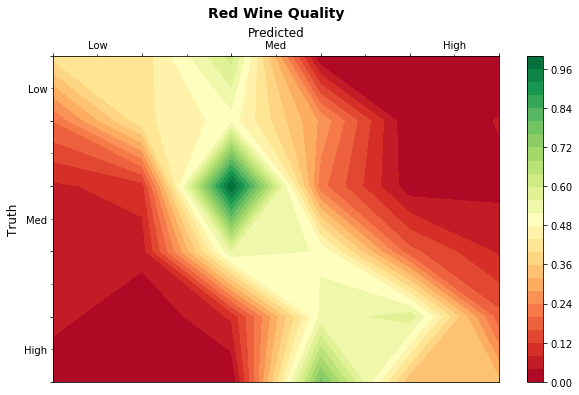

In [308]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_confusion_matrix(y_test, lr2_pred, 
                                    normalize=True, cmap='RdYlGn', ax=ax)

discrete_heatmap(confusion_matrix(y_test, lr2_pred))

interpolated_heatmap(confusion_matrix(y_test, lr2_pred))

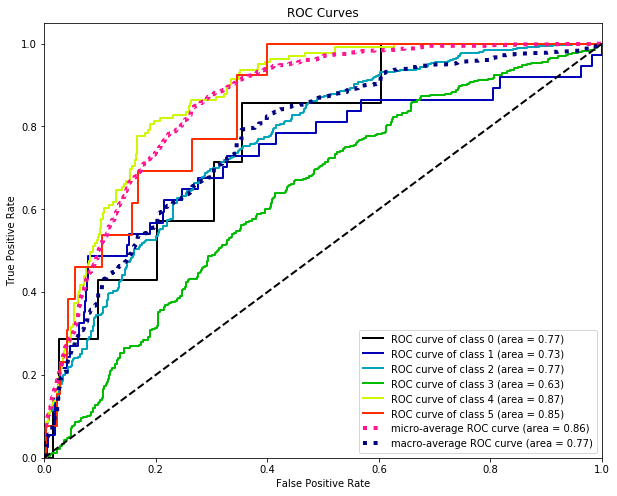

In [309]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr2_probas, ax=ax)

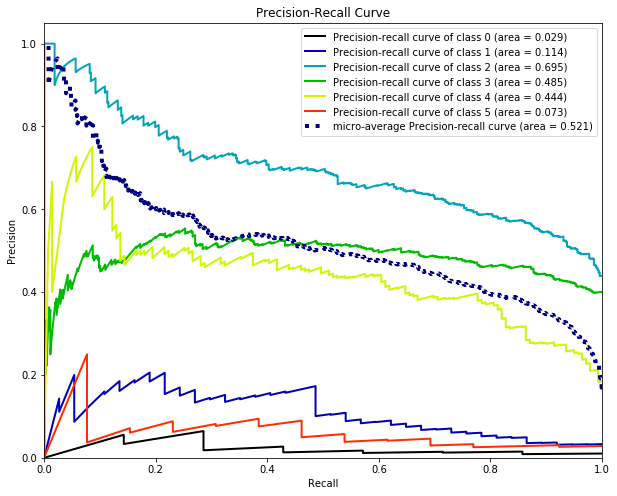

In [310]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr2_probas, ax=ax)

In [319]:
lr3.coef_.shape

(6, 7)

In [311]:
lr3 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='multinomial',
                         solver='newton-cg', max_iter=1000)
lr3.fit(X_train, y_train)

print(lr3)

# make predictions
lr3_pred = lr3.predict(X_test)
lr3_probas = lr3.predict_log_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr3_pred))
print(confusion_matrix(y_test, lr3_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
             precision    recall  f1-score   support

          0       0.03      0.29      0.05         7
          1       0.09      0.46      0.15        37
          2       0.63      0.51      0.56       477
          3       0.54      0.20      0.29       447
          4       0.37      0.58      0.45       139
          5       0.07      0.38      0.12        13

avg / total       0.53      0.39      0.42      1120

[[  2   3   2   0   0   0]
 [  4  17  10   4   1   1]
 [ 28 115 244  55  22  13]
 [ 29  58 130  91 108  31]
 [ 10   4   4  20  80  21]
 [  0   0   0   0   8   5]]


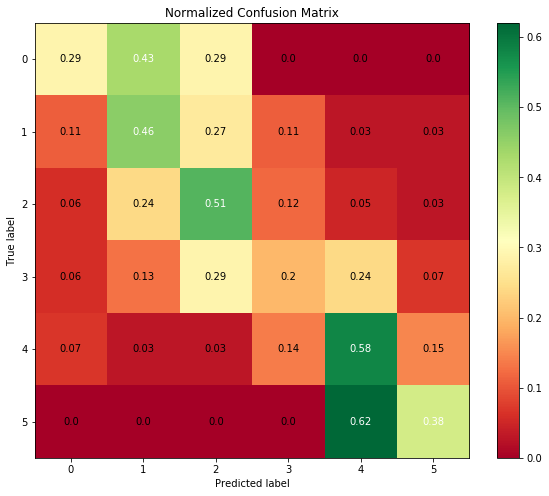

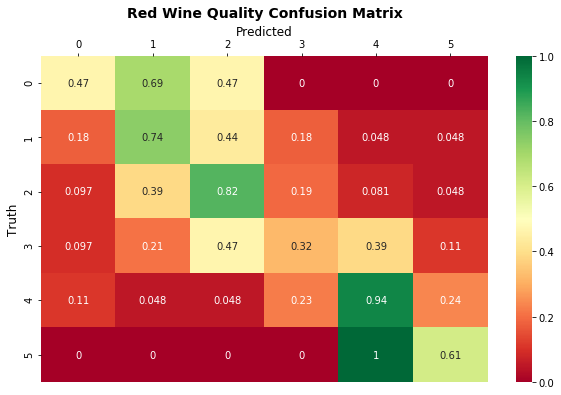

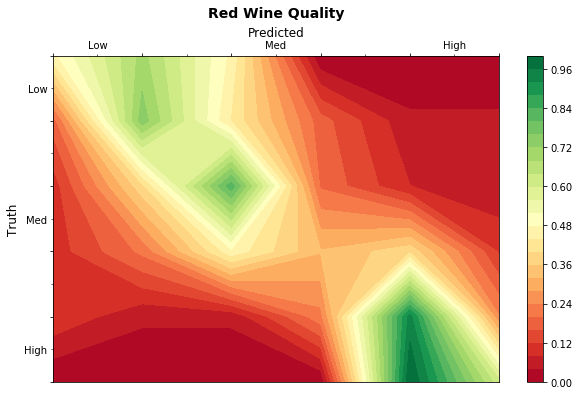

In [312]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_confusion_matrix(y_test, lr3_pred, 
                                    normalize=True, cmap='RdYlGn', ax=ax)

discrete_heatmap(confusion_matrix(y_test, lr3_pred))

interpolated_heatmap(confusion_matrix(y_test, lr3_pred))

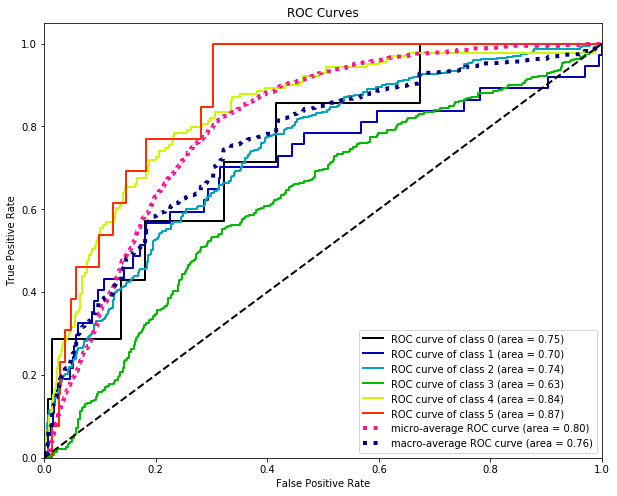

In [313]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr3_probas, ax=ax)

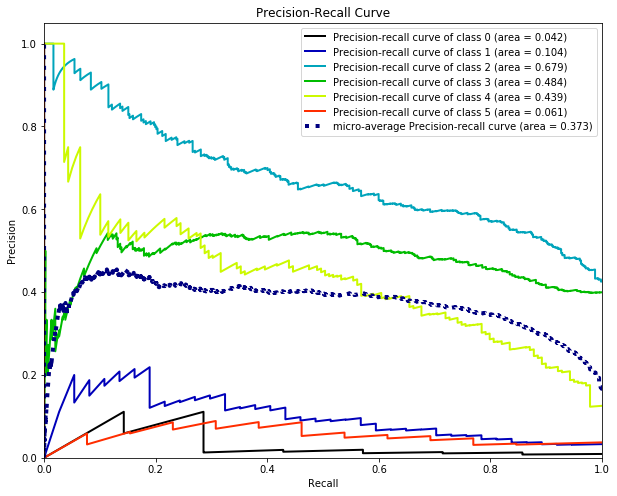

In [314]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr3_probas, ax=ax)

In [315]:
lr4 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='multinomial',
                         solver='lbfgs')
lr4.fit(X_train, y_train)

print(lr4)

# make predictions
lr4_pred = lr4.predict(X_test)
lr4_probas = lr4.predict_log_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr4_pred))
print(confusion_matrix(y_test, lr4_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)
             precision    recall  f1-score   support

          0       0.01      0.29      0.03         7
          1       0.08      0.46      0.14        37
          2       0.62      0.39      0.48       477
          3       0.57      0.26      0.36       447
          4       0.31      0.43      0.36       139
          5       0.07      0.46      0.12        13

avg / total       0.53      0.35      0.40      1120

[[  2   4   1   0   0   0]
 [  6  17  11   2   0   1]
 [ 80 114 186  52  32  13]
 [ 42  59  98 116  96  36]
 [  5   7   5  29  60  33]
 [  0   0   0   3   4   6]]


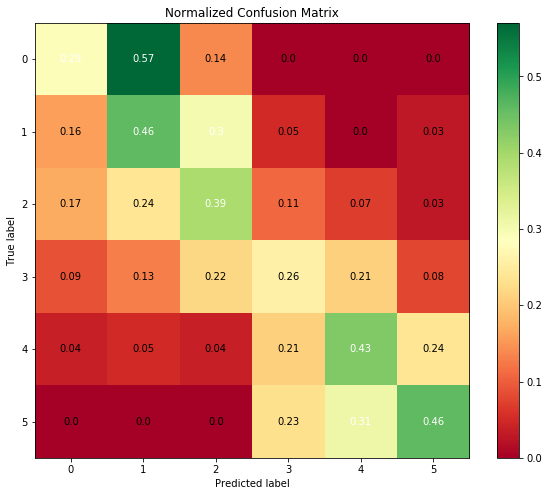

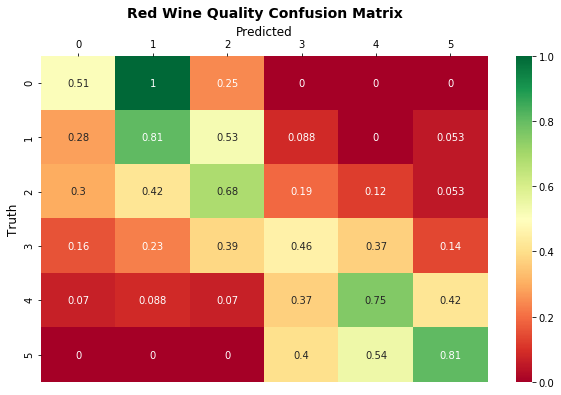

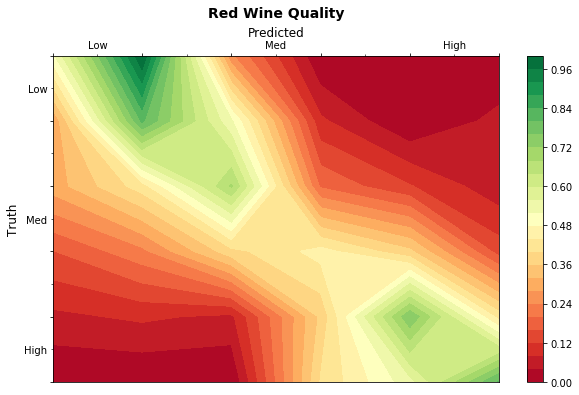

In [316]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_confusion_matrix(y_test, lr4_pred, 
                                    normalize=True, cmap='RdYlGn', ax=ax)

discrete_heatmap(confusion_matrix(y_test, lr4_pred))

interpolated_heatmap(confusion_matrix(y_test, lr4_pred))

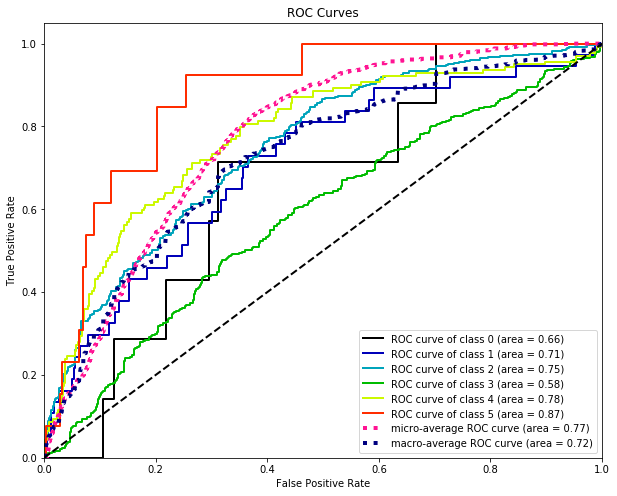

In [101]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr4_probas, ax=ax)

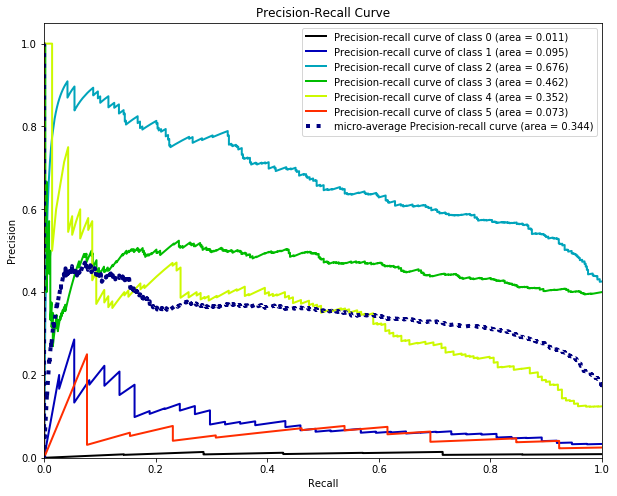

In [102]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr4_probas, ax=ax)

In [123]:
lr5 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='multinomial',
                         solver='sag',
                         max_iter=10000*2.5)
lr5.fit(X_train, y_train)

print(lr5)

# make predictions
lr5_pred = lr5.predict(X_test)
lr5_probas = lr5.predict_log_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr5_pred))
print(confusion_matrix(y_test, lr5_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=25000.0,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='sag', tol=0.0001, verbose=0,
          warm_start=False)
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         7
          1       0.09      0.43      0.15        37
          2       0.67      0.52      0.59       477
          3       0.55      0.29      0.38       447
          4       0.34      0.51      0.41       139
          5       0.07      0.46      0.12        13

avg / total       0.55      0.42      0.46      1120

[[  0   4   3   0   0   0]
 [  1  16  12   7   0   1]
 [ 14 105 249  83  18   8]
 [ 18  52 102 130 111  34]
 [  4   1   6  16  71  41]
 [  0   0   0   0   7   6]]


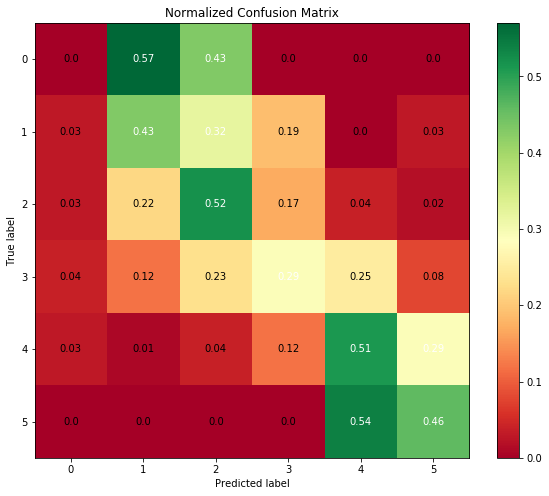

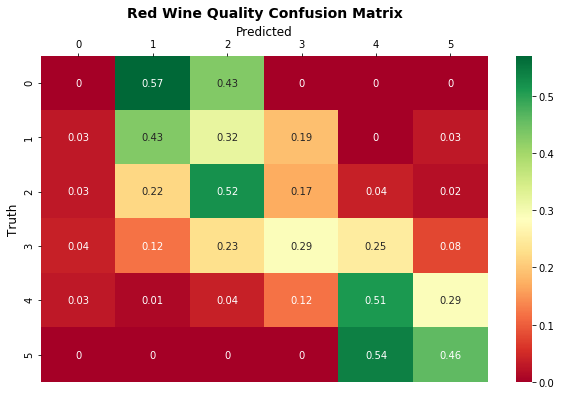

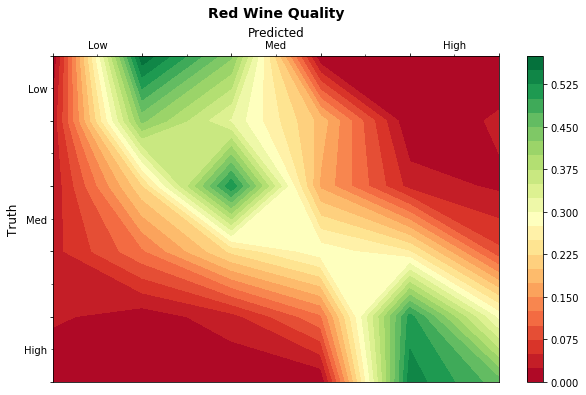

In [159]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_confusion_matrix(y_test, lr5_pred, 
                                    normalize=True, cmap='RdYlGn', ax=ax)

discrete_heatmap(confusion_matrix(y_test, lr5_pred))

interpolated_heatmap(confusion_matrix(y_test, lr5_pred))

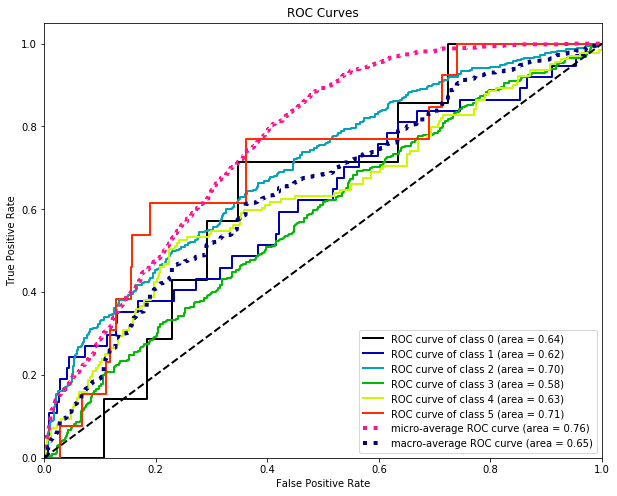

In [103]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr5_probas, ax=ax)

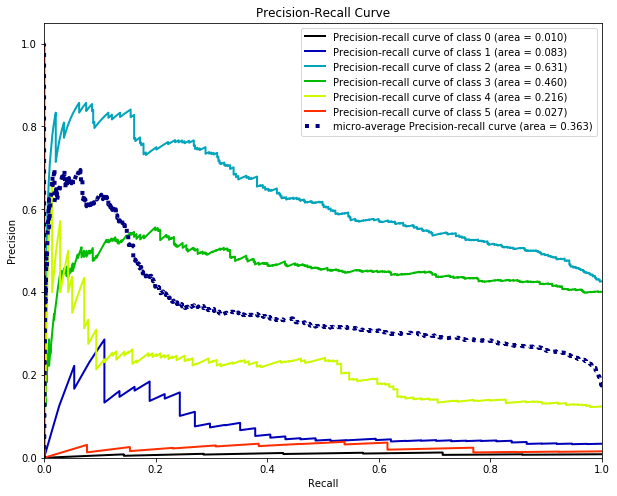

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr5_probas, ax=ax)

In [125]:
lr6 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='multinomial',
                         solver='saga',
                         max_iter=10000*2.5)
lr6.fit(X_train, y_train)

print(lr6)

# make predictions
lr6_pred = lr6.predict(X_test)
lr6_probas = lr6.predict_log_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr6_pred))
print(confusion_matrix(y_test, lr6_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=25000.0,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         7
          1       0.10      0.46      0.16        37
          2       0.66      0.53      0.59       477
          3       0.56      0.29      0.38       447
          4       0.35      0.48      0.41       139
          5       0.06      0.46      0.11        13

avg / total       0.55      0.42      0.46      1120

[[  0   4   3   0   0   0]
 [  1  17  12   6   0   1]
 [ 15 104 252  81  17   8]
 [ 19  52 109 128  98  41]
 [  5   1   7  15  67  44]
 [  0   0   0   0   7   6]]


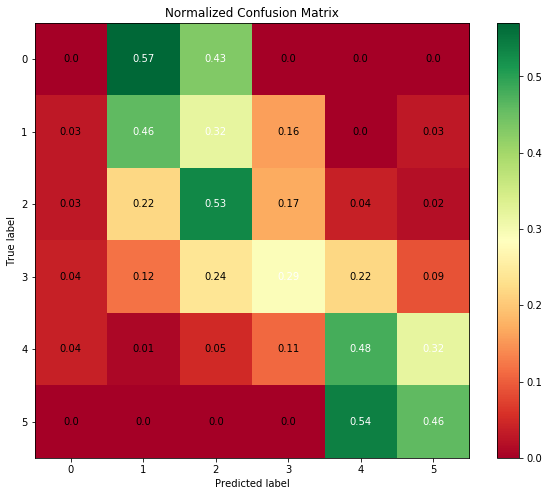

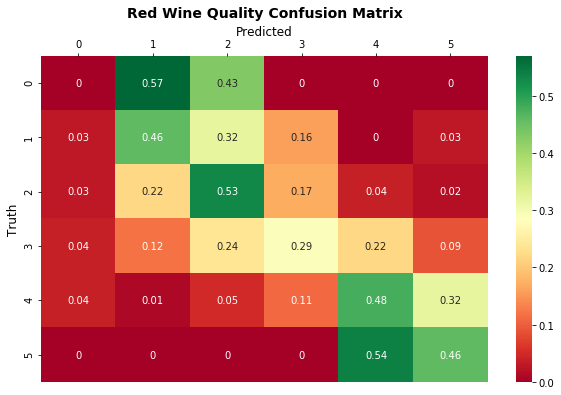

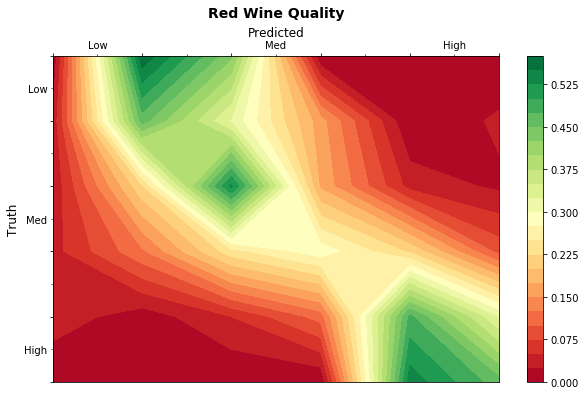

In [160]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_confusion_matrix(y_test, lr6_pred, 
                                    normalize=True, cmap='RdYlGn', ax=ax)

discrete_heatmap(confusion_matrix(y_test, lr6_pred))

interpolated_heatmap(confusion_matrix(y_test, lr6_pred))

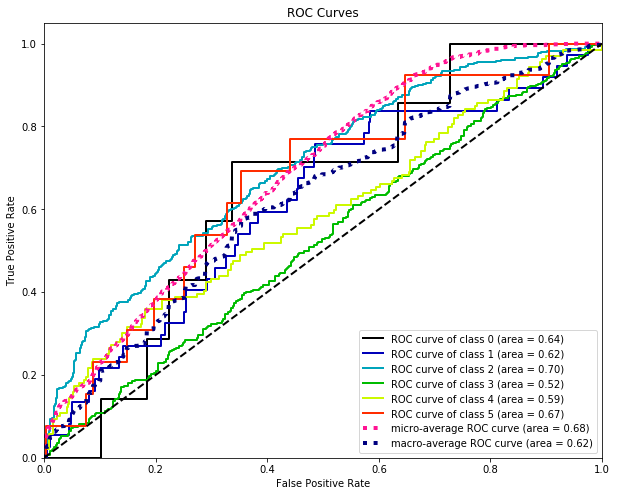

In [105]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr6_probas, ax=ax)

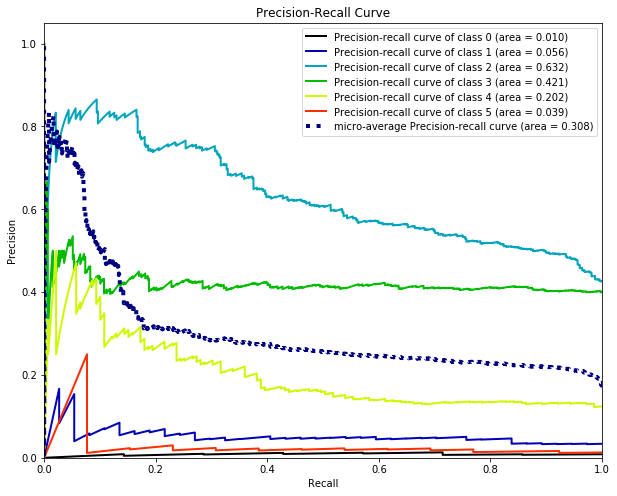

In [106]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr6_probas, ax=ax)

### Plot ROC Curves

In [16]:
from sklearn.preprocessing import LabelBinarizer

In [17]:
# Binarize the output
classes = sorted(y.unique())
print(classes)
# y2 = label_binarize(y, classes=classes)
lb = LabelBinarizer()
y2 = lb.fit_transform(y)
n_classes = y2.shape[1]
# Resplit using same seed
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=.7, random_state=129)

[0, 1, 2, 3, 4, 5]


In [43]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(C=1000, class_weight='balanced', random_state=129))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
y_pred = classifier.predict(X_test)
y_probas = classifier.predict_proba(X_test)

print(classifier)
# print(classification_report(y_test, y_pred))
print(classification_report(lb.inverse_transform(y_test), lb.inverse_transform(y_pred)))
print(confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred)))

OneVsRestClassifier(estimator=LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=129,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=1)
             precision    recall  f1-score   support

          0       0.03      0.25      0.06         8
          1       0.07      0.40      0.12        43
          2       0.62      0.46      0.53       489
          3       0.55      0.50      0.52       443
          4       0.30      0.10      0.15       127
          5       0.00      0.00      0.00        10

avg / total       0.52      0.43      0.46      1120

[[  2   4   2   0   0   0]
 [  5  17  15   6   0   0]
 [ 21 161 226  70  11   0]
 [ 34  60 111 220  18   0]
 [  1   3  12  97  13   1]
 [  0   0   0   9   1   0]]


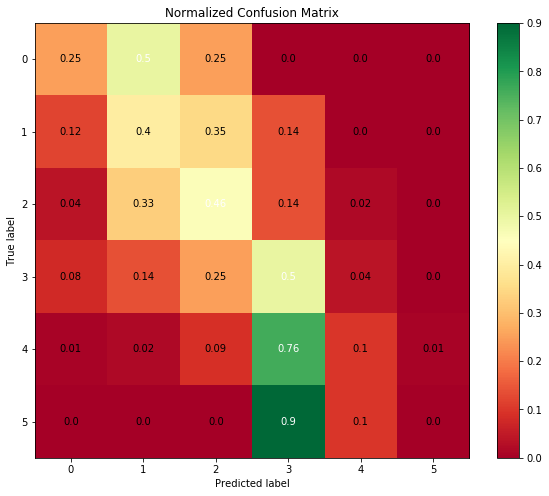

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_confusion_matrix(lb.inverse_transform(y_test), 
                                    lb.inverse_transform(y_pred), 
                                    normalize=True, cmap='RdYlGn', ax=ax)

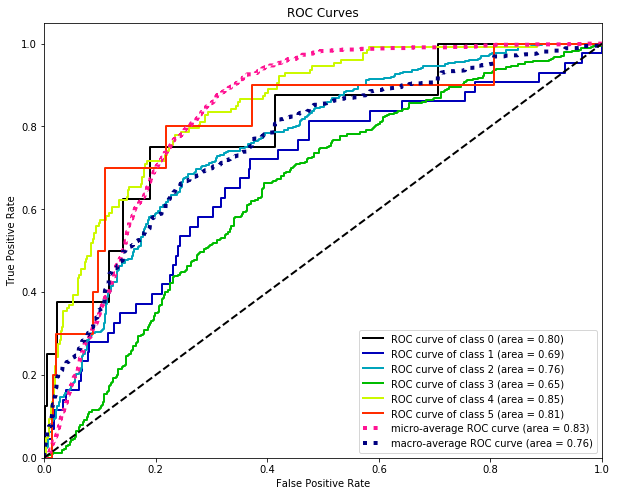

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(lb.inverse_transform(y_test), y_probas, ax=ax)

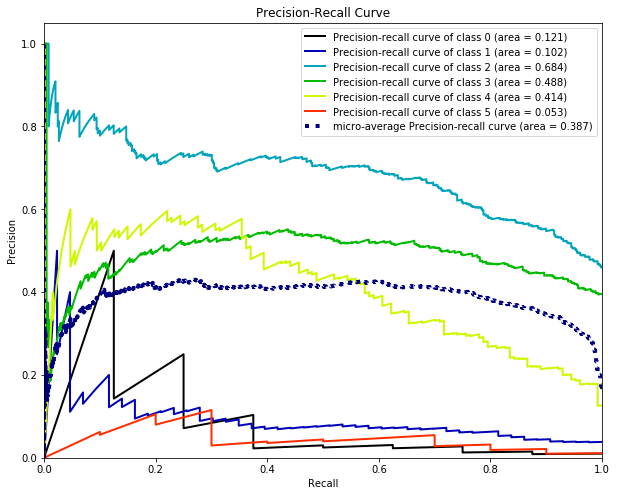

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(lb.inverse_transform(y_test), y_probas, ax=ax)

In [55]:
skplt.metrics.plot_calibration_curve([lb.inverse_transform(y_test)], [y_probas])

ValueError: plot_calibration_curve only works for binary classification